This notebook provides a short sample on how to evaluate your trained model. We will continue from our previous notebook `03_` which has trained a working model. 

The complete evaluation script can be found in the root directory of the repository `eval_iter.py` or `eval_ensemble.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
pl.seed_everything(42)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_theme(context='paper')

# Adjusting global plotting parameters
plt.rcParams['font.size'] = 40        # Adjusts the main font size
plt.rcParams['axes.labelsize'] = 32   # Font size of x and y labels
plt.rcParams['xtick.labelsize'] = 32  # Font size of numbers on x-axis
plt.rcParams['ytick.labelsize'] = 32  # Font size of numbers on y-axis
plt.rcParams['legend.fontsize'] = 32  # Font size of legend

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import model, mlp, cnn, ae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[rank: 0] Global seed set to 42


In [3]:
# Handle for evaluation
metrics = ['rmse', 'acc', 'bias', 'ssim', 'sdiv']
headline_vars = dict({'t-850': 'K', 'z-500': 'gpm', 'q-700': r'$10^{-3}kg kg^{-1}$'})

In [4]:
# Handle consistent limit for plotting
y_lim = {
    'rmse': {'t-850': {'min': 0.5, 'max': 6}, 'z-500': {'min': 0, 'max': 150}, 'q-700': {'min': 0.0005, 'max': 0.0030}},
    'acc': {'t-850': {'min': -0.3, 'max': 1}, 'z-500': {'min': -0.3, 'max': 1}, 'q-700': {'min': -0.3, 'max': 1}},
    'bias': {'t-850': {'min': -2.0, 'max': 1}, 'z-500': {'min': -40, 'max': 40}, 'q-700': {'min': -0.0005, 'max': 0.0005}},
    'ssim': {'t-850': {'min': 0.6, 'max': 1}, 'z-500': {'min': 0.6, 'max': 1}, 'q-700': {'min': 0.3, 'max': 1}}
}

## Data-driven models

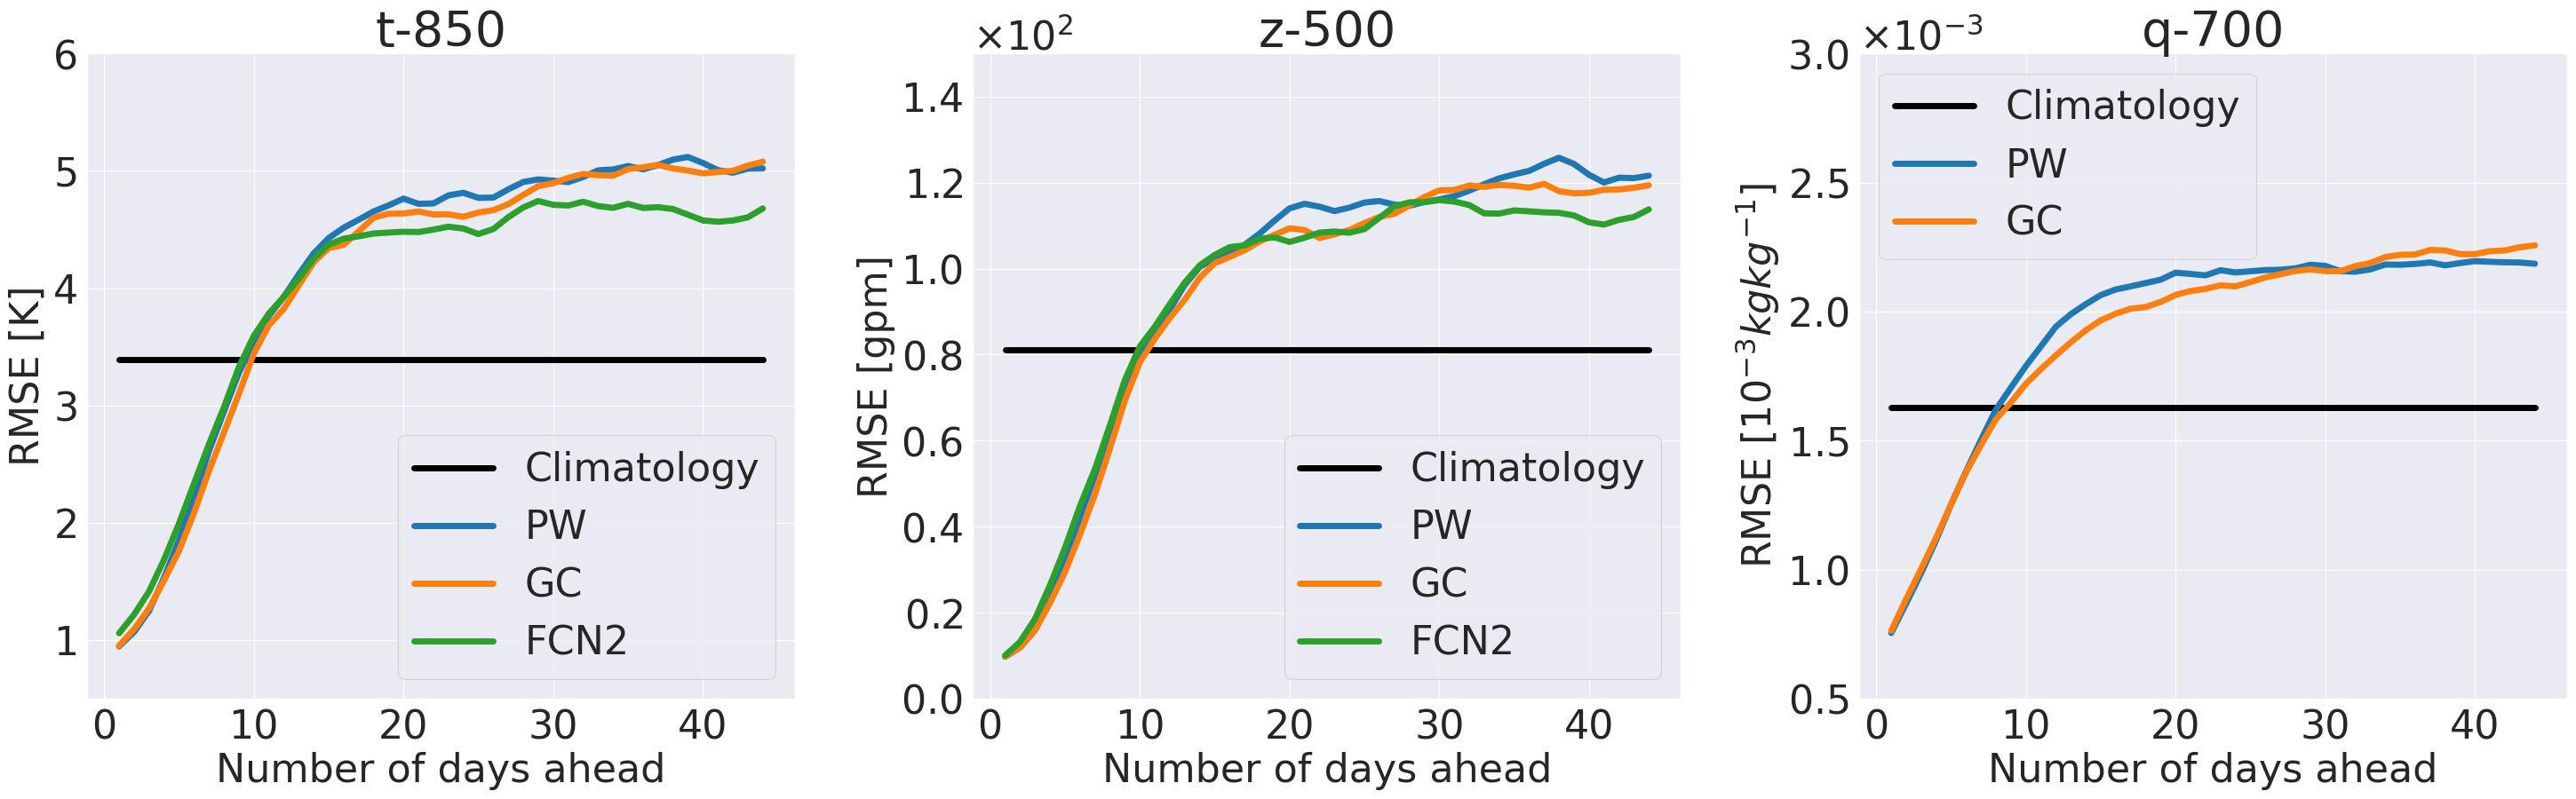

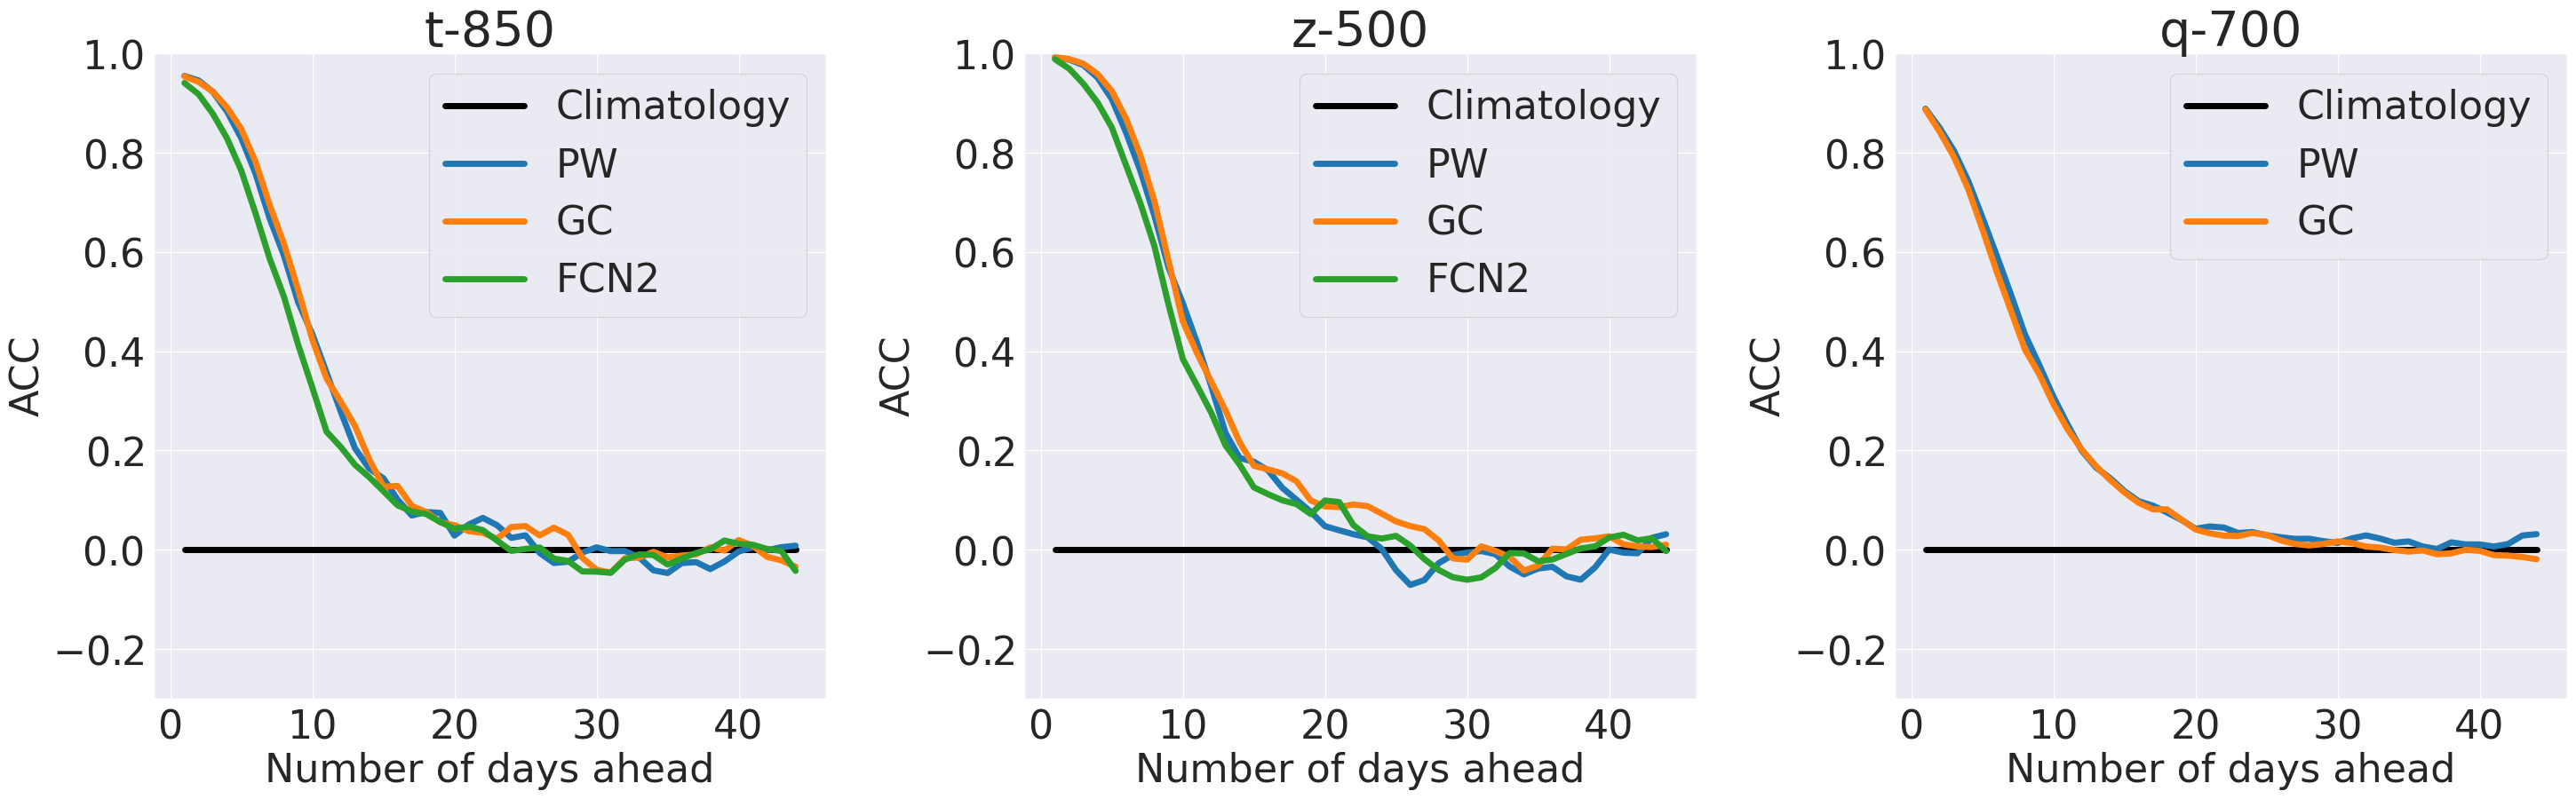

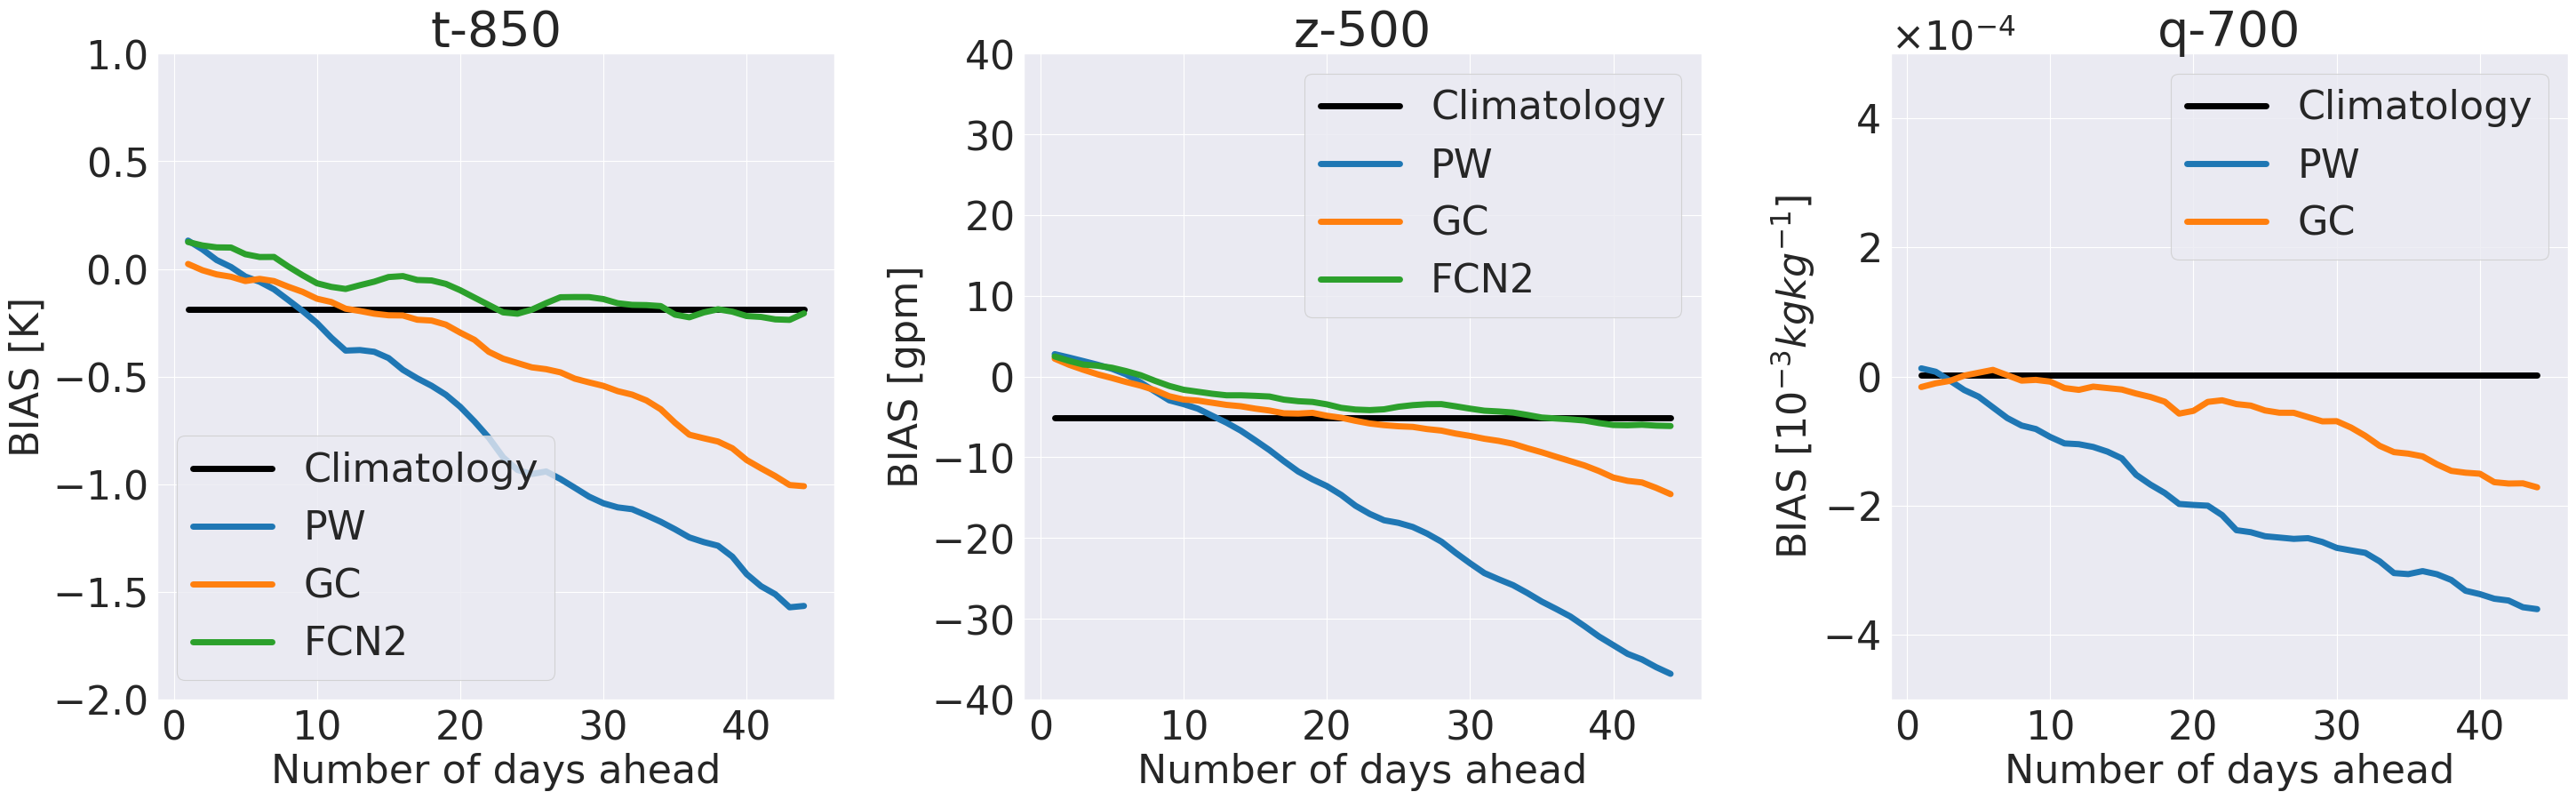

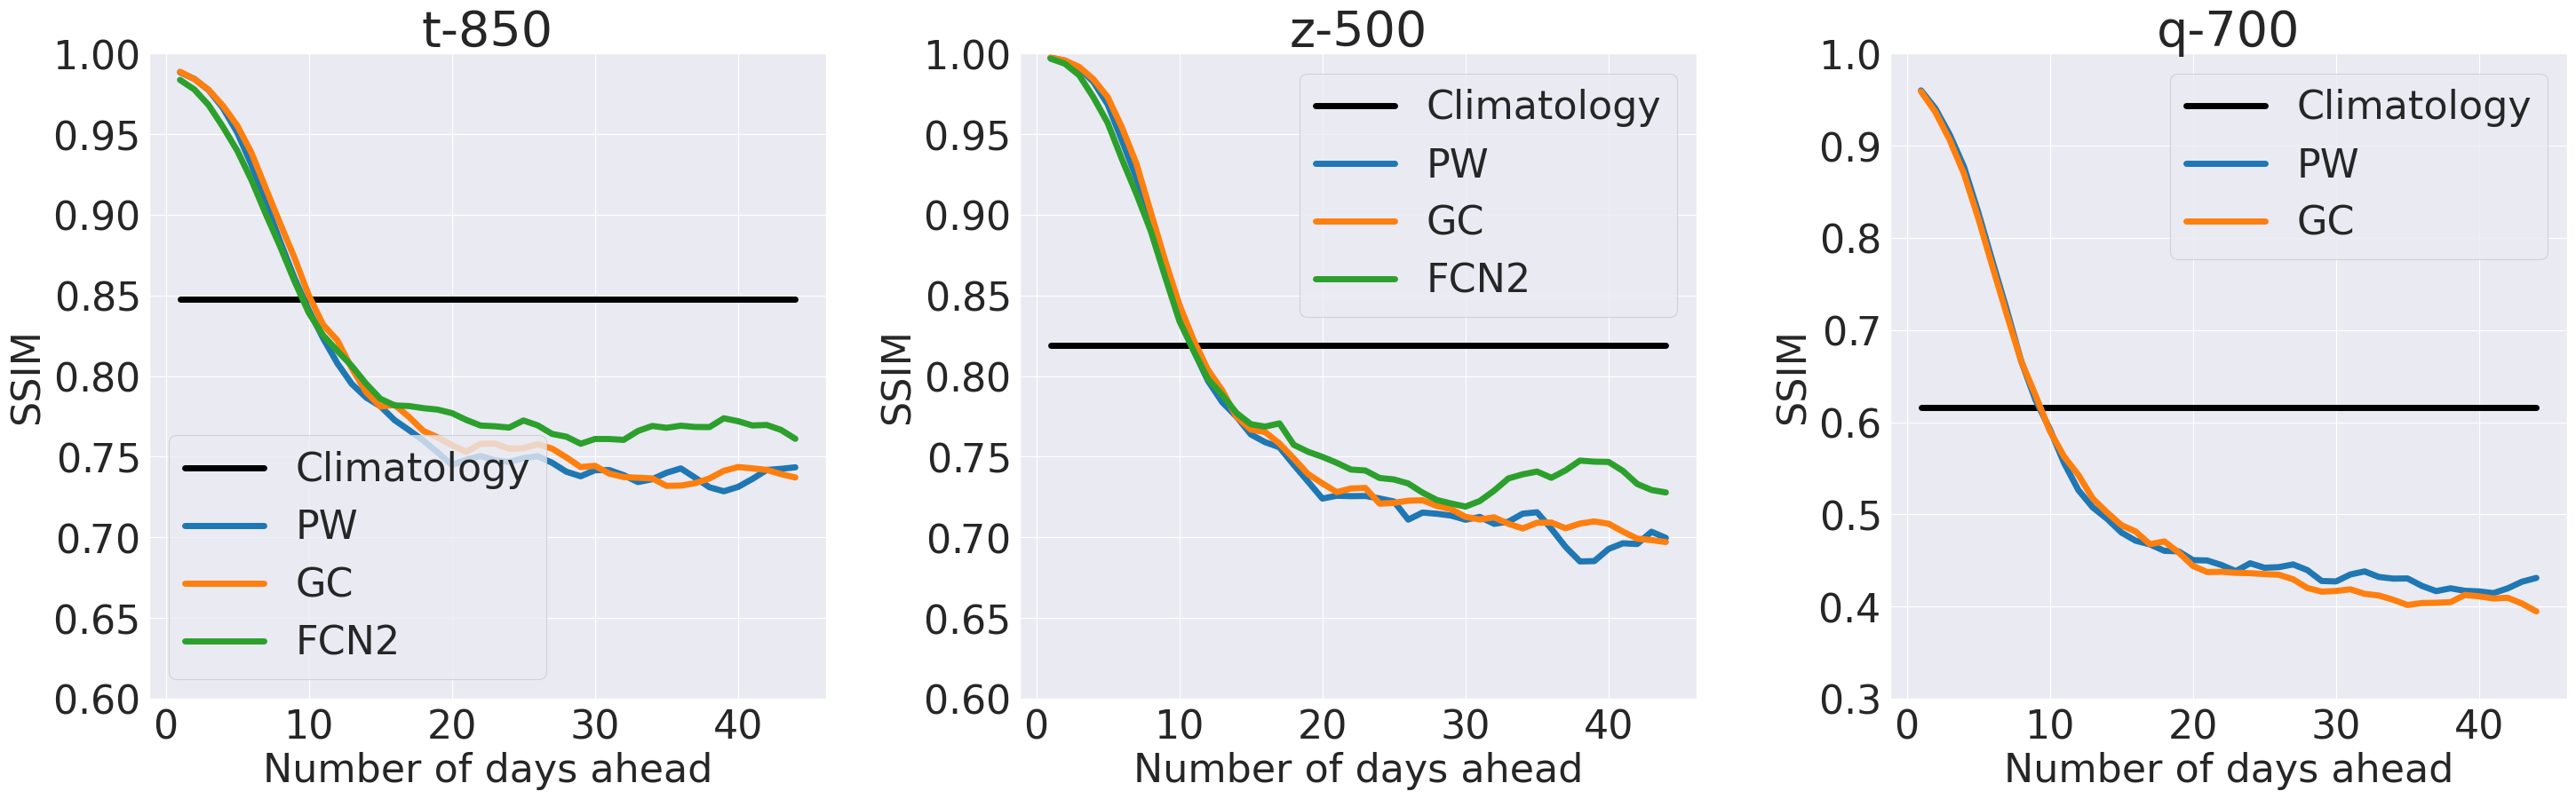

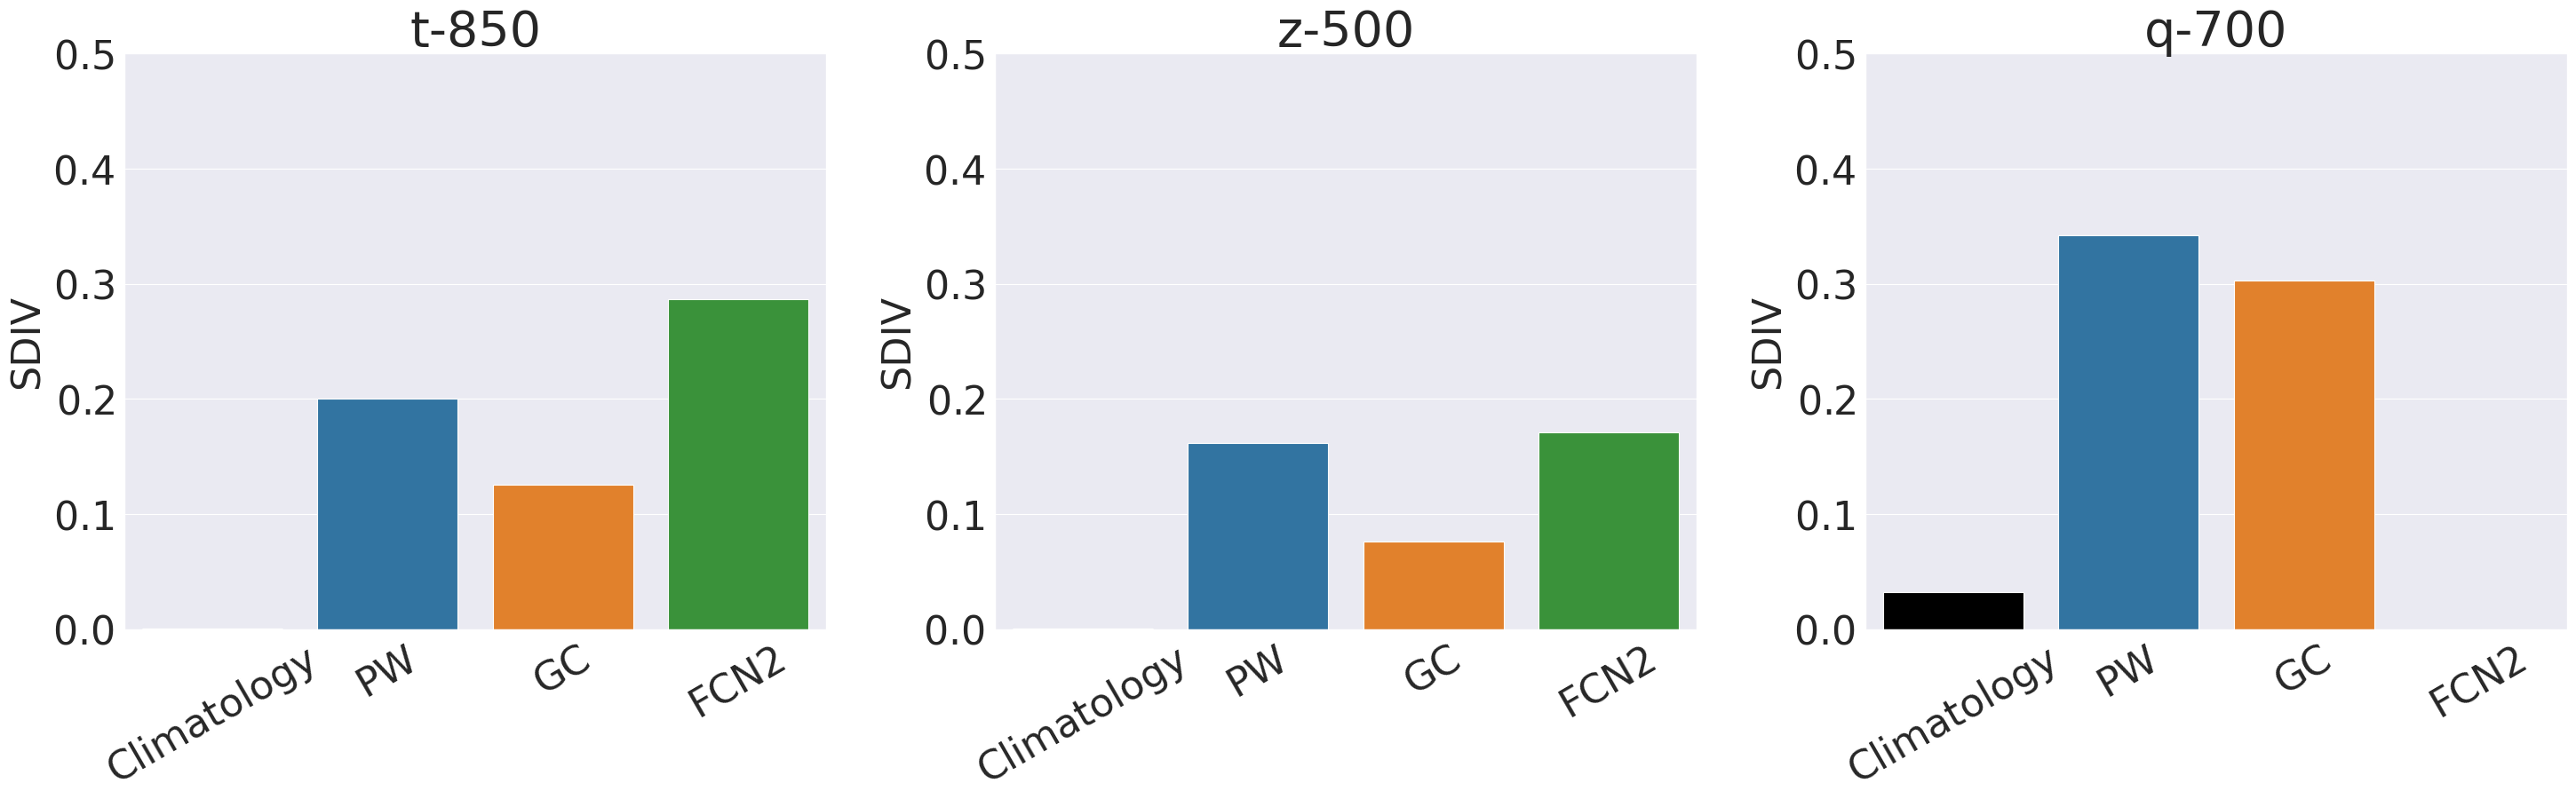

In [5]:
# Evaluate metrics across data-driven models
linecolors = ['black', '#1f77b4', '#ff7f0e', '#2ca02c', '#C44E52']
model_names = ['climatology', 'panguweather', 'graphcast', 'fourcastnetv2']
labels = ['Climatology', 'PW', 'GC', 'FCN2']

# Iterate over each metric
for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Plot
        for model_idx, model_name in enumerate(model_names):
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
            
            try:
                y = df[[headline_var]].to_numpy().squeeze()

                # Calculate the average of all timesteps if the metric requires a bar plot
                if metric in ['sres', 'sdiv']:
                    average_y = np.nanmean(y)  # Use nanmean to handle NaN values safely
                    data_to_plot.append({'Model': labels[model_idx], 'Average': average_y})
                    bar = sns.barplot(
                        x='Model',
                        y='Average',
                        data=pd.DataFrame(data_to_plot),
                        ax=ax,
                        palette=linecolors
                    )
                    ax.set_ylim(0, 0.5)
                    bar.set_xticklabels(bar.get_xticklabels(), rotation=30) 
                
                # Otherwise plot each model's line
                else:
                    if (y.mean() != 0.0) or (model_name == 'climatology'):  # Only plot if the mean is not zero
                        
                        sns.lineplot(
                            x=np.arange(1, df.shape[0]+1),
                            y=y, 
                            label=labels[model_idx],
                            linewidth=5,
                            color=linecolors[model_idx],
                            ax=ax
                        )
                    ax.set_ylim(y_lim[metric][headline_var]['min'], y_lim[metric][headline_var]['max'])
                
            except:
                pass

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead' 
        y_label = f'{metric.upper()}' if metric in ['acc', 'ssim', 'sres', 'sdiv'] else f'{metric.upper()} [{headline_unit}]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2,2))
        ax.yaxis.set_major_formatter(formatter)

        # Show legend if it's not a bar plot for sres or sdiv
        if metric not in ['sres', 'sdiv']:
            ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/sota_{metric}.pdf', dpi=200, bbox_inches='tight');

### Physics-based models

In [ ]:
# Evaluate metrics across physics-based models maintained by different centers
# Case 1a: control forecasts
metrics = ['rmse', 'acc', 'bias', 'ssim', 'sdiv']
linecolors = {'climatology': 'black', 'ecmwf': '#1f77b4', 'cma': '#ff7f0e', 'ukmo': '#2ca02c', 'ncep': '#C44E52'}
model_names = {'climatology': 'Climatology', 'ecmwf': 'ECMWF', 'cma': 'CMA', 'ukmo': 'UKMO', 'ncep': 'NCEP'}

# Iterate over each metric
for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10 * len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Plot
        for model_name, model_label in model_names.items():
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
            y = df[headline_var].to_numpy()

            if metric in ['sres', 'sdiv']:
                y = np.nanmean(y)
                data_to_plot.append({'Model': model_label, 'Average': y})
            
            else:
                if (np.nanmean(df) != 0.0) or (model_name == 'climatology'):
                    sns.lineplot(
                        x=np.arange(1, df.shape[0]+1),
                        y=y,
                        label=f'{model_names[model_name]}',
                        linewidth=5,
                        linestyle='-',
                        color=linecolors[model_name],
                        ax=ax
                    )
                
                ax.set_ylim(y_lim[metric][headline_var]['min'], y_lim[metric][headline_var]['max'])
                

        # Plot bar for metrics that require it
        if metric in ['sres', 'sdiv']:
            bar = sns.barplot(
                x='Model',
                y='Average',
                data=pd.DataFrame(data_to_plot),
                ax=ax,
                palette=[linecolors[name.split()[0].lower()] for name in model_names.values()]
            )
            
            ax.set_ylim(0, 0.5)
            bar.set_xticklabels(bar.get_xticklabels(), rotation=30)

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead'
        y_label = f'{metric.upper()}' if metric in ['acc', 'ssim', 'sres', 'sdiv'] else f'{metric.upper()} [{headline_unit}]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        ax.yaxis.set_major_formatter(formatter)

        # Show legend if it's not a bar plot for sres or sdiv
        if metric not in ['sres', 'sdiv']:
            ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/center_{metric}.pdf', dpi=200, bbox_inches='tight')

In [ ]:
# Evaluate metrics across physics-based models maintained by different centers
# Case 1b: ensemble
metrics = ['rmse', 'acc', 'bias', 'ssim', 'sdiv']
linecolors = {'climatology': 'black', 'ecmwf': '#1f77b4', 'cma': '#ff7f0e', 'ukmo': '#2ca02c', 'ncep': '#C44E52'}
model_names = {'climatology': 'Climatology', 'ecmwf': 'ECMWF (n=50)', 'cma': 'CMA (n=3)', 'ukmo': 'UKMO (n=3)', 'ncep': 'NCEP (n=15)'}

# Iterate over each metric
for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10 * len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Plot
        for model_name, model_label in model_names.items():
            if model_name == 'climatology':
                df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
            else:
                df = pd.read_csv(Path(f'../logs/{model_name}_ensemble/eval/{metric}_{model_name}.csv'))
            
            y = df[headline_var].to_numpy()

            if metric in ['sres', 'sdiv']:
                y = np.nanmean(y)
                data_to_plot.append({'Model': model_label, 'Average': y})
            else:
                if (np.nanmean(df) != 0.0) or (model_name == 'climatology'):
                    sns.lineplot(
                        x=np.arange(1, df.shape[0]+1),
                        y=y,
                        label=f'{model_names[model_name]}',
                        linewidth=5,
                        linestyle='-',
                        color=linecolors[model_name],
                        ax=ax
                    )
                

        # Plot bar for metrics that require it
        if metric in ['sres', 'sdiv']:
            bar = sns.barplot(
                x='Model',
                y='Average',
                data=pd.DataFrame(data_to_plot),
                ax=ax,
                palette=[linecolors[name.split()[0].lower()] for name in model_names.values()]
            )
            bar.set_xticklabels(bar.get_xticklabels(), rotation=30)

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead'
        y_label = f'{metric.upper()}' if metric in ['acc', 'ssim', 'sres', 'sdiv'] else f'{metric.upper()} [{headline_unit}]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        ax.yaxis.set_major_formatter(formatter)

        # Show legend if it's not a bar plot for sres or sdiv
        if metric not in ['sres', 'sdiv']:
            ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/center_ens_{metric}.pdf', dpi=200, bbox_inches='tight')

In [ ]:
# Evaluate metrics across physics-based models maintained by different centers
# Case 1c: ensemble/deterministic ratio
metrics = ['rmse', 'acc', 'bias', 'ssim', 'sdiv']
linecolors = {'ecmwf': '#1f77b4', 'cma': '#ff7f0e', 'ukmo': '#2ca02c', 'ncep': '#C44E52'}
model_names = {'ecmwf': 'ECMWF (n=50)', 'cma': 'CMA (n=3)', 'ukmo': 'UKMO (n=3)', 'ncep': 'NCEP (n=15)'}

# Iterate over each metric
for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10 * len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Plot the ratio between control and ensemble models
        for model_name, model_label in model_names.items():
            control_df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
            ensemble_df = pd.read_csv(Path(f'../logs/{model_name}_ensemble/eval/{metric}_{model_name}.csv'))
            
            control_y = control_df[headline_var].to_numpy()
            ensemble_y = ensemble_df[headline_var].to_numpy()

            if len(control_y) != len(ensemble_y):
                raise ValueError(f"Length mismatch between control and ensemble for {model_name}")

            # Calculate the ratio
            ratio_y = ensemble_y / control_y

            if metric in ['sres', 'sdiv']:
                average_ratio_y = np.nanmean(ratio_y)
                data_to_plot.append({'Model': model_label, 'Average': average_ratio_y})
            else:
                if np.nanmean(ratio_y) != 0.0:
                    sns.lineplot(
                        x=np.arange(1, len(ratio_y) + 1),
                        y=ratio_y,
                        label=f'{model_names[model_name]}',
                        linewidth=5,
                        linestyle='-',
                        color=linecolors[model_name],
                        ax=ax
                    )
                    

        # Plot bar for metrics that require it
        if metric in ['sres', 'sdiv']:
            bar = sns.barplot(
                x='Model',
                y='Average',
                data=pd.DataFrame(data_to_plot),
                ax=ax,
                palette=[linecolors[name.split()[0].lower()] for name in model_names.values()]
            )
            bar.set_xticklabels(bar.get_xticklabels(), rotation=30)

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead'
        y_label = f'{metric.upper()} [ens/det]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        ax.yaxis.set_major_formatter(formatter)

        # Show legend if it's not a bar plot for sres or sdiv
        if metric not in ['sres', 'sdiv']:
            ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/center_ratio_{metric}.pdf', dpi=200, bbox_inches='tight')

In [ ]:
# Evaluate metrics across physics-based models maintained by different centers
# Case 2: probabilistic metrics
metrics = ['crps', 'crpss', 'spread', 'ssr']
linecolors = {'ecmwf': '#1f77b4', 'cma': '#ff7f0e', 'ukmo': '#2ca02c', 'ncep': '#C44E52'}
model_names = {'ecmwf': 'ECMWF (n=50)', 'cma': 'CMA (n=3)', 'ukmo': 'UKMO (n=3)', 'ncep': 'NCEP (n=15)'}

for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Collect and plot data for this headline variable
        for model_name, model_label in model_names.items():
            
            df = pd.read_csv(Path(f'../logs/{model_name}_ensemble/eval/{metric}_{model_name}.csv'))
            y = df[[headline_var]].to_numpy().squeeze()

            if y.mean() != 0.0:  # Only plot if the mean is not zero
                    
                sns.lineplot(
                    x=np.arange(1, df.shape[0]+1),
                    y=y, 
                    label=model_label,
                    linewidth=5,
                    color=linecolors[model_name],
                    ax=ax
                )
            

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead' 
        y_label = f'{metric.upper()}' if metric in ['crpss', 'ssr'] else f'{metric.upper()} [{headline_unit}]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2,2))
        ax.yaxis.set_major_formatter(formatter)
        ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/center_probs_{metric}.pdf', dpi=200, bbox_inches='tight');


### Ablation 1: Autoregressive vs direct training...

In [ ]:
# Evaluate metrics across direct vs autoregressive approaches
metrics = ['rmse', 'bias', 'ssim', 'sdiv']
linecolors = {'climatology': 'black', 'climax/direct_1': '#1f77b4', 'panguweather': '#ff7f0e', 'graphcast': '#2ca02c', 'fourcastnetv2': '#C44E52'}
model_names = {'climatology': 'Climatology', 'climax/direct_1': 'ClimaX/Direct', 'panguweather': 'PW/Autoreg', 'graphcast': 'GC/Autoreg', 'fourcastnetv2': 'FCN2/Autoreg'}

for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Collect and plot data for this headline variable
        for model_name, model_label in model_names.items():
            if 'climax' in model_name or 's2s' in model_name:
                model_basename, model_task = model_name.split('/')
                df = pd.read_csv(Path(f'../logs/{model_basename}/eval/{model_task}/{metric}_{model_basename}.csv'))

            else:
                df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
            
            try:
                y = df[[headline_var]].to_numpy().squeeze()

                # Calculate the average of all timesteps if the metric requires a bar plot
                if metric in ['sres', 'sdiv']:
                    average_y = np.nanmean(y)  # Use nanmean to handle NaN values safely
                    data_to_plot.append({'Model': model_name, 'Average': average_y})
                    bar = sns.barplot(
                        x='Model',
                        y='Average',
                        data=pd.DataFrame(data_to_plot),
                        label=model_label,
                        ax=ax,
                        palette=linecolors
                    )
                    bar.set_xticklabels(bar.get_xticklabels(), rotation=15) 
                
                # Otherwise plot each model's line
                else:
                    if y.mean() != 0.0:  # Only plot if the mean is not zero
                        sns.lineplot(
                            x=np.arange(1, df.shape[0]+1),
                            y=y, 
                            label=model_label,
                            linewidth=5,
                            color=linecolors[model_name],
                            ax=ax
                        )
                
            except:
                pass

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead' 
        y_label = f'{metric.upper()}' if metric in ['acc', 'ssim', 'sres', 'sdiv'] else f'{metric.upper()} [{headline_unit}]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2,2))
        ax.yaxis.set_major_formatter(formatter)

        # Show legend if it's not a bar plot for sres or sdiv
        if metric not in ['sres', 'sdiv']:
            ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show();
    f.savefig(f'../docs/time_{metric}.pdf', dpi=200, bbox_inches='tight');


### Ablation 2: Boundary Conditions

In [ ]:
# Evaluate metrics without and with BC 
metrics = ['rmse', 'acc', 'ssim']
model_names = {'resnet_s2s': ['version_0', 'version_4'], 'unet_s2s': ['version_0', 'version_22']}
labels = ['ResNet', 'UNet']

all_data = []

for metric_idx, metric in enumerate(metrics):
    
    # Iterate over each headline variable
    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):

        # Collect data for this headline variable
        for model_idx, (model_name, versions) in enumerate(model_names.items()):
            for version_idx, version in enumerate(versions):
                df = pd.read_csv(Path(f'../logs/{model_name}/eval/{version}/{metric}_{model_name}.csv'))
                last_value = df[headline_var].iloc[-1] # Get the last timestep

                # Append data with additional detail
                all_data.append({
                    'Metric': metric,
                    'Variable': headline_var,
                    'Model': labels[model_idx],
                    'Condition': ("w/o BC", "with BC")[version_idx],
                    'Value': last_value
                })

# Convert to DataFrame
all_data = pd.DataFrame(all_data)
all_data = all_data.pivot_table(index=['Metric', 'Variable', 'Model'], columns='Condition',  values='Value', aggfunc='mean') 
all_data

### Ablation 3: ML Ensembles

In [ ]:
# Evaluate metrics across data-driven models
# Case 3a: ensemble/deterministic ratio
metrics = ['rmse', 'acc', 'bias', 'ssim', 'sdiv']
linecolors = {'unet': '#1f77b4', 'resnet': '#ff7f0e'}
model_names = {'unet': 'UNet (n=5)', 'resnet': 'ResNet (n=5)'}

# Iterate over each metric
for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10 * len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Plot the ratio between control and ensemble models
        for model_name, model_label in model_names.items():
            control_df = pd.read_csv(Path(f'../logs/{model_name}_s2s/eval/version_0/{metric}_{model_name}_s2s.csv'))
            ensemble_df = pd.read_csv(Path(f'../logs/{model_name}_ensemble_s2s/eval/{metric}_{model_name}_ensemble_s2s.csv'))
            
            control_y = control_df[headline_var].to_numpy()
            ensemble_y = ensemble_df[headline_var].to_numpy()

            if len(control_y) != len(ensemble_y):
                raise ValueError(f"Length mismatch between control and ensemble for {model_name}")

            # Calculate the ratio
            ratio_y = ensemble_y / control_y

            if metric in ['sres', 'sdiv']:
                average_ratio_y = np.nanmean(ratio_y)
                data_to_plot.append({'Model': model_label, 'Average': average_ratio_y})
            else:
                if np.nanmean(ratio_y) != 0.0:
                    sns.lineplot(
                        x=np.arange(1, len(ratio_y) + 1),
                        y=ratio_y,
                        label=f'{model_names[model_name]}',
                        linewidth=5,
                        linestyle='-',
                        color=linecolors[model_name],
                        ax=ax
                    )
                    

        # Plot bar for metrics that require it
        if metric in ['sres', 'sdiv']:
            bar = sns.barplot(
                x='Model',
                y='Average',
                data=pd.DataFrame(data_to_plot),
                ax=ax,
                palette=[linecolors[name.split()[0].lower()] for name in model_names.values()]
            )
            bar.set_xticklabels(bar.get_xticklabels(), rotation=30)

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead'
        y_label = f'{metric.upper()} [ens/det]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        ax.yaxis.set_major_formatter(formatter)

        # Show legend if it's not a bar plot for sres or sdiv
        if metric not in ['sres', 'sdiv']:
            ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/ml_ratio_{metric}.pdf', dpi=200, bbox_inches='tight')

In [ ]:
# Evaluate metrics across physics-based models maintained by different centers
# Case 3b: probabilistic metrics
metrics = ['crps', 'crpss', 'spread', 'ssr']
linecolors = {'unet': '#1f77b4', 'resnet': '#ff7f0e'}
model_names = {'unet': 'UNet (n=5)', 'resnet': 'ResNet (n=5)'}

for metric_idx, metric in enumerate(metrics):
    f, axes = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 10))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
        ax = axes[headline_idx] if len(headline_vars) > 1 else axes
        data_to_plot = []

        # Collect and plot data for this headline variable
        for model_name, model_label in model_names.items():
            
            df = pd.read_csv(Path(f'../logs/{model_name}_ensemble_s2s/eval/{metric}_{model_name}_ensemble_s2s.csv'))
            y = df[[headline_var]].to_numpy().squeeze()

            if y.mean() != 0.0:  # Only plot if the mean is not zero
                    
                sns.lineplot(
                    x=np.arange(1, df.shape[0]+1),
                    y=y, 
                    label=model_label,
                    linewidth=5,
                    color=linecolors[model_name],
                    ax=ax
                )
            

        # Customize labels and titles based on the metric
        x_label = '' if metric in ['sres', 'sdiv'] else 'Number of days ahead' 
        y_label = f'{metric.upper()}' if metric in ['crpss', 'ssr'] else f'{metric.upper()} [{headline_unit}]'
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{headline_var}', fontsize=40)

        # Setting the formatter for scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2,2))
        ax.yaxis.set_major_formatter(formatter)
        ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/ml_probs_{metric}.pdf', dpi=200, bbox_inches='tight');


## Prediction visualization

In [ ]:
#################### CHANGE THIS ####################
date_idx = 0
param = 't'
level = 850
model_name = 'resnet_s2s'

plot_idx = [1, config.N_STEPS - 1]
######################################################

## Dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)


## Load config filepath which consists of all the definition needed to fit/eval a model
log_dir = Path('../logs') / model_name
model_config_filepath = Path(f'../chaosbench/configs/{model_name}.yaml')

with open(model_config_filepath, 'r') as config_filepath:
    hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']
param_level_idx = utils.get_param_level_idx(param, level)

## Checkpointing
versions = ['version_0', 'version_1', 'version_2', 'version_3']

for version in versions:
    all_preds = list()
    all_truth = list()
    
    S = 'S=1' if (('0' in version) or ('2' in version)) else 'S=5'
    task = 'Task 1' if (('0' in version) or ('1' in version)) else 'Task 2'
    
    ckpt_filepath = log_dir / f'lightning_logs/{version}/checkpoints/'
    ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
    baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
    baseline = baseline.load_from_checkpoint(ckpt_filepath)
    
    with torch.no_grad():
    
        timestamp, input_x, input_y = input_dataset[date_idx]
        _, output_x, output_y = output_dataset[date_idx]

        curr_x = input_x.unsqueeze(0).to(device)

        for step_idx in range(config.N_STEPS - 1):
            preds = baseline(curr_x)
            curr_y = output_y.unsqueeze(0)[:, step_idx + 1]

            if step_idx + 1 in plot_idx:
                all_preds.append(preds[0][param_level_idx].detach().cpu().numpy())
                all_truth.append(curr_y[0][param_level_idx].detach().cpu().numpy())

            curr_x = preds 
            
    # Plotting
    all_preds = np.array(all_preds)
    all_truth = np.array(all_truth)

    f, ax = plt.subplots(3, len(plot_idx), figsize=(8, 3 * len(plot_idx)))

    for time_idx in range(len(plot_idx)):

        im0 = ax[0, time_idx].imshow(all_truth[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
        # ax[0, time_idx].set_title(f'Truth\n(step={plot_idx[time_idx]})')
        ax[0, time_idx].axis('off')
        cbar0 = f.colorbar(im0, ax=ax[0, time_idx], shrink=0.8)

        im1 = ax[1, time_idx].imshow(all_preds[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
        # ax[1, time_idx].set_title(f'Prediction\n(step={plot_idx[time_idx]})')
        ax[1, time_idx].axis('off')
        cbar1 = f.colorbar(im1, ax=ax[1, time_idx], shrink=0.8)

        im2 = ax[2, time_idx].imshow(all_preds[time_idx] - all_truth[time_idx], cmap='RdBu_r', vmin=-1, vmax=1)
        # ax[2, time_idx].set_title(f'Residual\n(step={plot_idx[time_idx]})')
        ax[2, time_idx].axis('off')
        cbar2 = f.colorbar(im2, ax=ax[2, time_idx], shrink=0.8)

    # Adding titles for each row
    titles = [r'$Truth$', r'$Prediction$', r'$Residual$']
    for idx, title in enumerate(titles):
        f.text(-0.01, 0.82 - idx*0.32, title, va='center', ha='left', fontsize=12, rotation=90)

    ax[0,0].set_title(f'{task} ({S})\n norm-{param}{level}\n t = 1', fontsize=12)
    ax[0,1].set_title(f'{task} ({S})\n norm-{param}{level}\n t = 44', fontsize=12)
    plt.tight_layout()
    plt.show()
    # f.savefig(f'../docs/preds_{model_name}_{param}{level}_{S}_{task}.pdf', dpi=200, bbox_inches='tight');


## Power spectrum

In [ ]:
#################### CHANGE THIS ####################
date_idx = 0
n_steps = [0, 43]
model_type = 'unet'
task = 1
######################################################

param_levels = [['t', 850], ['z', 500], ['q', 700]]

if task == 1:
    model_list = [
        dict({f'Task_{task}/S=1': f'{model_type}_s2s/version_0', 
              f'Task_{task}/S=5': f'{model_type}_s2s/version_1'}), # task 1
    ]
    
else:
    model_list = [
        dict({f'Task_{task}/S=1': f'{model_type}_s2s/version_2', 
              f'Task_{task}/S=5': f'{model_type}_s2s/version_3'}), # task 2
    ]

In [ ]:
# Plot individual spectra at t=1 and t=44
all_Sk = dict()

## Initialize dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

# Compute power spectrum for each model and its configuration
f, ax = plt.subplots(len(n_steps), len(param_levels), figsize=(10*len(param_levels), 10*len(n_steps)))


for i, param_level in enumerate(param_levels):
    param = param_level[0]
    level = param_level[1]
    param_level_idx = utils.get_param_level_idx(param, level)

    for model_item in model_list:

        for _, (model_spec, model_name) in enumerate(model_item.items()):
            print(f'Processing {model_spec}')

            all_preds, all_truth = list(), list()

            model_basename, model_version = model_name.split('/')

            log_dir = Path('../logs') / model_basename
            model_config_filepath = Path(f'../chaosbench/configs/{model_basename}.yaml')

            with open(model_config_filepath, 'r') as config_filepath:
                hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

            model_args = hyperparams['model_args']
            data_args = hyperparams['data_args']

            # Load checkpoints
            ckpt_filepath = log_dir / f'lightning_logs/{model_version}/checkpoints/'
            ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
            baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
            baseline = baseline.load_from_checkpoint(ckpt_filepath)

            with torch.no_grad():

                timestamp, input_x, input_y = input_dataset[date_idx]
                _, output_x, output_y = output_dataset[date_idx]

                curr_x = input_x.unsqueeze(0).to(device)

                for step_idx in range(config.N_STEPS - 1):
                    preds = baseline(curr_x)
                    curr_y = output_y.unsqueeze(0)[:, step_idx + 1]

                    all_preds.append(
                        preds[0][param_level_idx].detach().cpu().numpy()
                    )

                    all_truth.append(
                        curr_y[0][param_level_idx].detach().cpu().numpy()
                    )

                    curr_x = preds 

            all_preds, all_truth = np.array(all_preds), np.array(all_truth)


            # Plot power spectrum
            curr_pred_Sk, curr_truth_Sk = list(), list()

            for step_idx in range(all_preds.shape[0]):
                pred_t, truth_t = all_preds[step_idx], all_truth[step_idx]
                pred_power_t, truth_power_t = np.fft.fft2(pred_t), np.fft.fft2(truth_t)
                pred_power_t, truth_power_t = np.abs(pred_power_t)**2, np.abs(truth_power_t)**2

                ny, nx = pred_t.shape
                kx = np.fft.fftfreq(nx) * nx
                ky = np.fft.fftfreq(ny) * ny

                kx, ky = np.meshgrid(kx, ky)
                k = np.sqrt(kx**2 + ky**2)

                k_bins = np.arange(0.5, np.max(k), 1)
                k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
                pred_Sk = np.histogram(k, bins=k_bins, weights=pred_power_t)[0] / np.histogram(k, bins=k_bins)[0]
                truth_Sk = np.histogram(k, bins=k_bins, weights=truth_power_t)[0] / np.histogram(k, bins=k_bins)[0]

                curr_pred_Sk.append(pred_Sk)
                curr_truth_Sk.append(truth_Sk)

                if step_idx in n_steps:
                    step_num = n_steps.index(step_idx)
                    ax[step_num, i].set_title(f'{param}-{level}', fontsize=24)
                    ax[step_num, i].loglog(pred_Sk, label=f'{model_spec}', linewidth=3)
                    ax[step_num, i].set_xlabel('Wavenumber, k')
                    ax[step_num, i].set_ylabel(f'Power, S(k); {step_idx + 1}-day ahead')
                    ax[step_num, i].set_ylim([10**0, 10**7])
                    ax[step_num, i].legend()

            all_Sk[f'{model_spec}:{param}-{level}'] = np.array(curr_pred_Sk)
            all_Sk['truth'] = np.array(curr_truth_Sk)

plt.show()
f.savefig(f'../docs/specdiv_{model_type}_Task {task}.pdf', dpi=200, bbox_inches='tight');

In [ ]:
# Plot full power spectra
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def set_log_ticks_10_power(axis, num_ticks=5):
    lims = axis.get_data_interval()
    
    ticks = np.linspace(lims[0], lims[1], num=num_ticks)
    axis.set_ticks(ticks)
    axis.set_ticklabels([f'$10^{{{int(tick)}}}$' for tick in ticks])


eps = 1e-50 # to void log(0)
task_s = list(model_list[0].keys())
f = plt.figure(figsize=(16, 10))
subplot_idx = 1

for task_id, task in enumerate(task_s):
    task_num, step_size = task.split('/')
    
    for param_id, param_level in enumerate(param_levels):
        
        curr_Sk = all_Sk[f'{task}:{param_level[0]}-{param_level[1]}']
    
        # Plot the 3D contour plot
        ax = f.add_subplot(len(task_s), len(param_levels), subplot_idx, projection='3d')
        Wavenumber, Timestep = np.meshgrid(np.arange(1, curr_Sk.shape[1] + 1), np.arange(1, curr_Sk.shape[0] + 1))
        contour = ax.contour3D(np.log10(Wavenumber + eps), Timestep, np.log10(curr_Sk + eps), 100, cmap='inferno_r')

        ax.set_xlabel('Wavenumber, k')
        ax.set_ylabel('Number of days ahead')
        ax.set_zlabel(r'Power, S(k)', labelpad=0.1)

        set_log_ticks_10_power(ax.xaxis)
        set_log_ticks_10_power(ax.zaxis)
        
        ax.set_title(f'{task_num} ({step_size})\n {param_level[0]}{param_level[1]}', fontsize=12)
        subplot_idx += 1

plt.show()
f.savefig(f'../docs/3d_{model_type}_{task_num}.pdf', dpi=200, bbox_inches='tight');

## Effects of temporal information
For autoregressive approach...

In [ ]:
# Plot metrics over time, across tasks

model_list = [
    dict({'S=1': 'unet_s2s/version_0', 'S=5': 'unet_s2s/version_1'}), # task 1
    # dict({'Task_2/S=1': 'unet_s2s/version_2', 'Task_2/S=5': 'unet_s2s/version_3'}), # task 2
]

metrics = ['rmse', 'acc', 'ssim', 'sdiv']
headline_vars = dict({'t-850': 'K', 'z-500': 'gpm', 'q-700': r'$10^{-3}kg kg^{-1}$'})

for metric in metrics:
    
    f, ax = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 8))
    
    for model_item in model_list:
    
        for model_idx, (model_spec, model_name) in enumerate(model_item.items()):
        
            model_basename, version_num = model_name.split('/')
            df = pd.read_csv(Path(f'../logs/{model_basename}/eval/{version_num}/{metric}_{model_basename}.csv'))

            for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
                
                if 'q' in headline_var and metric == 'rmse':
                    y = df[[headline_var]].to_numpy().squeeze() * 1000 
                
                else:
                    y = df[[headline_var]].to_numpy().squeeze()

                sns.lineplot(
                    x=np.arange(1, df.shape[0]+1),
                    y=y, 
                    label=f'{model_spec}',
                    linewidth=5,
                    ax=ax[headline_idx]
                )

                ## Labeling
                ax[headline_idx].set_xlim([0,45])
                ax[headline_idx].set_xlabel('Number of days ahead')
                
                if metric == 'rmse':
                    ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
                    
                elif metric == 'sdiv':
                    ax[headline_idx].set_ylabel(f'{metric.upper()}')
                    
                else:
                    ax[headline_idx].set_ylabel(f'{metric.upper()}')
                    ax[headline_idx].set_ylim([0,1])
                    
                ax[headline_idx].set_title(f'{headline_var}', fontsize=40)
                
    f.savefig(f'../docs/autoreg_{metric}_task1.pdf', dpi=200, bbox_inches='tight');
            
plt.show()